In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
import math
import seaborn as sns
import json

In [2]:
sns.set()
sns.set_palette("husl")

In [3]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

RANDOM_SEED=75

OUTPUT_PATH = './'
CONTOUR_EXTRACT_MODE = cv2.RETR_TREE

In [4]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [31]:
# df = pd.DataFrame({'id':train_ids,'train_or_test':'train'})
# df= df.append(pd.DataFrame({'id':test_ids,'train_or_test':'test'}))
print("number of train images: ",len(train_ids))
print("number of test images: ", len(test_ids))

number of train images:  670
number of test images:  65


The results are shown in the table below.

|train_or_test|# of imgs|# of nuclei|
|------|-----|------|
|test|65|unknown|
|train|670|29461|

In [16]:
# average number of nuclei in train image
train_mask_paths = [glob.glob(os.path.join(TRAIN_PATH, train_id, "masks","*")) for train_id in train_ids]
N = len(train_mask_paths)
count=[]
for i in range(N):
    count.append(len(train_mask_paths[i]))
sum(count)/len(count)

43.971641791044775

In [32]:
from sklearn.cluster import KMeans

def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

In [39]:
def get_image_info(path, clusters=2):
    image = cv2.imread(path)
    height,width,_ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters = clusters)
    clt.fit(image)
    hist = centroid_histogram(clt)
    
    bg_idx, fg_idx = 0, clusters-1
    if hist[bg_idx] < hist[fg_idx]:
        bg_idx, fg_idx = clusters-1, 0
    
    bg_red, bg_green, bg_blue = clt.cluster_centers_[bg_idx]
    fg_red, fg_green, fg_blue = clt.cluster_centers_[fg_idx]
    
    bg_color = sum(clt.cluster_centers_[bg_idx])/3
    fg_color = sum(clt.cluster_centers_[fg_idx])/3
    max_color_pct = hist[bg_idx]
    min_color_pct = hist[fg_idx]
    
    return (pd.Series([height,width,
                       bg_red, bg_green, bg_blue, bg_color,
                       fg_red, fg_green, fg_blue, fg_color,
                       hist[bg_idx],hist[fg_idx],
                       fg_color < bg_color]))

In [42]:
df['path'] = df.apply(lambda x:'./input/stage1_{}/{}/images/{}.png'.format(x[1],x[0],x[0]), axis=1)
image_info = os.path.join(OUTPUT_PATH,'images.json')

if os.path.isfile(image_info):
    with open(image_info, 'r') as datafile:
        data = json.load(datafile)
        df = pd.read_json(path_or_buf=data, orient='records')
        data = None
else:
    names = ['height','width',
             'bg_red', 'bg_green', 'bg_blue','bg_color',
             'fg_red', 'fg_green', 'fg_blue','fg_color',
             'bg_color_pct','fg_color_pct','invert']

    df[names] = df['path'].apply(lambda x: get_image_info(x))
    df['shape'] = df[['height','width']].apply(lambda x: '{:04d}x{:04d}'.format(x[0], x[1]), axis=1)

    with open(image_info, 'w') as outfile:
        json.dump(df.to_json(orient='records'), outfile)

In [43]:
len(df['shape'].unique()),len(df['width'].unique()), len(df['height'].unique())

(16, 15, 11)

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

In [45]:
agg = df[['shape','train_or_test','id']].groupby(['shape','train_or_test']).count().unstack()
agg.columns = agg.columns.droplevel()

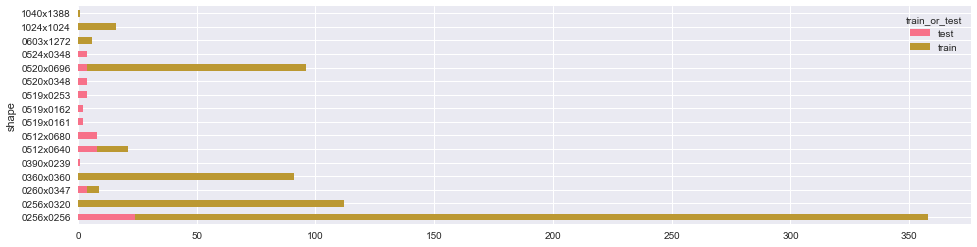

In [46]:
agg.plot.barh(stacked=True,figsize=(16,4))
plt.show()

In [47]:
agg[agg['train'].isnull()]

train_or_test,test,train
shape,,
0390x0239,1.0,NaN
0512x0680,8.0,NaN
0519x0161,2.0,NaN
0519x0162,2.0,NaN
0519x0253,4.0,NaN
0520x0348,4.0,NaN
0524x0348,4.0,NaN


In [48]:
def show_image(ax,title,image):
    ax.grid(None)
    ax.set_title(title)
    ax.imshow(image)

In [49]:
def n_of_each(df, n = 4):
    shapes = df['shape'].unique()
    sample = pd.DataFrame()
    
    for shape in shapes:
        sample = sample.append(df[df['shape']==shape].sample(n, replace=True))
    
    return sample.sort_values(by=['shape']).reset_index()
def show_row_col(sample,cols,path_col='path',image_col=None,label_col='title',mode='file'):
    rows = math.ceil(len(sample)/cols)
    
    fig, ax = plt.subplots(rows,cols,figsize=(5*cols,5*rows))
    
    for index, data in sample.iterrows():
    
        title = data[label_col]
        if mode=='image':
            image = np.array(data[image_col],dtype=np.uint8)
            #image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        else:
            image = cv2.imread(data[path_col])
            image = cv2.cvtColor(image,cv2.COLOR_BGRA2RGB)

        row = index // cols
        col = index % cols
        show_image(ax[row,col],title,image)

    plt.show()

In [50]:
sample = n_of_each(df)

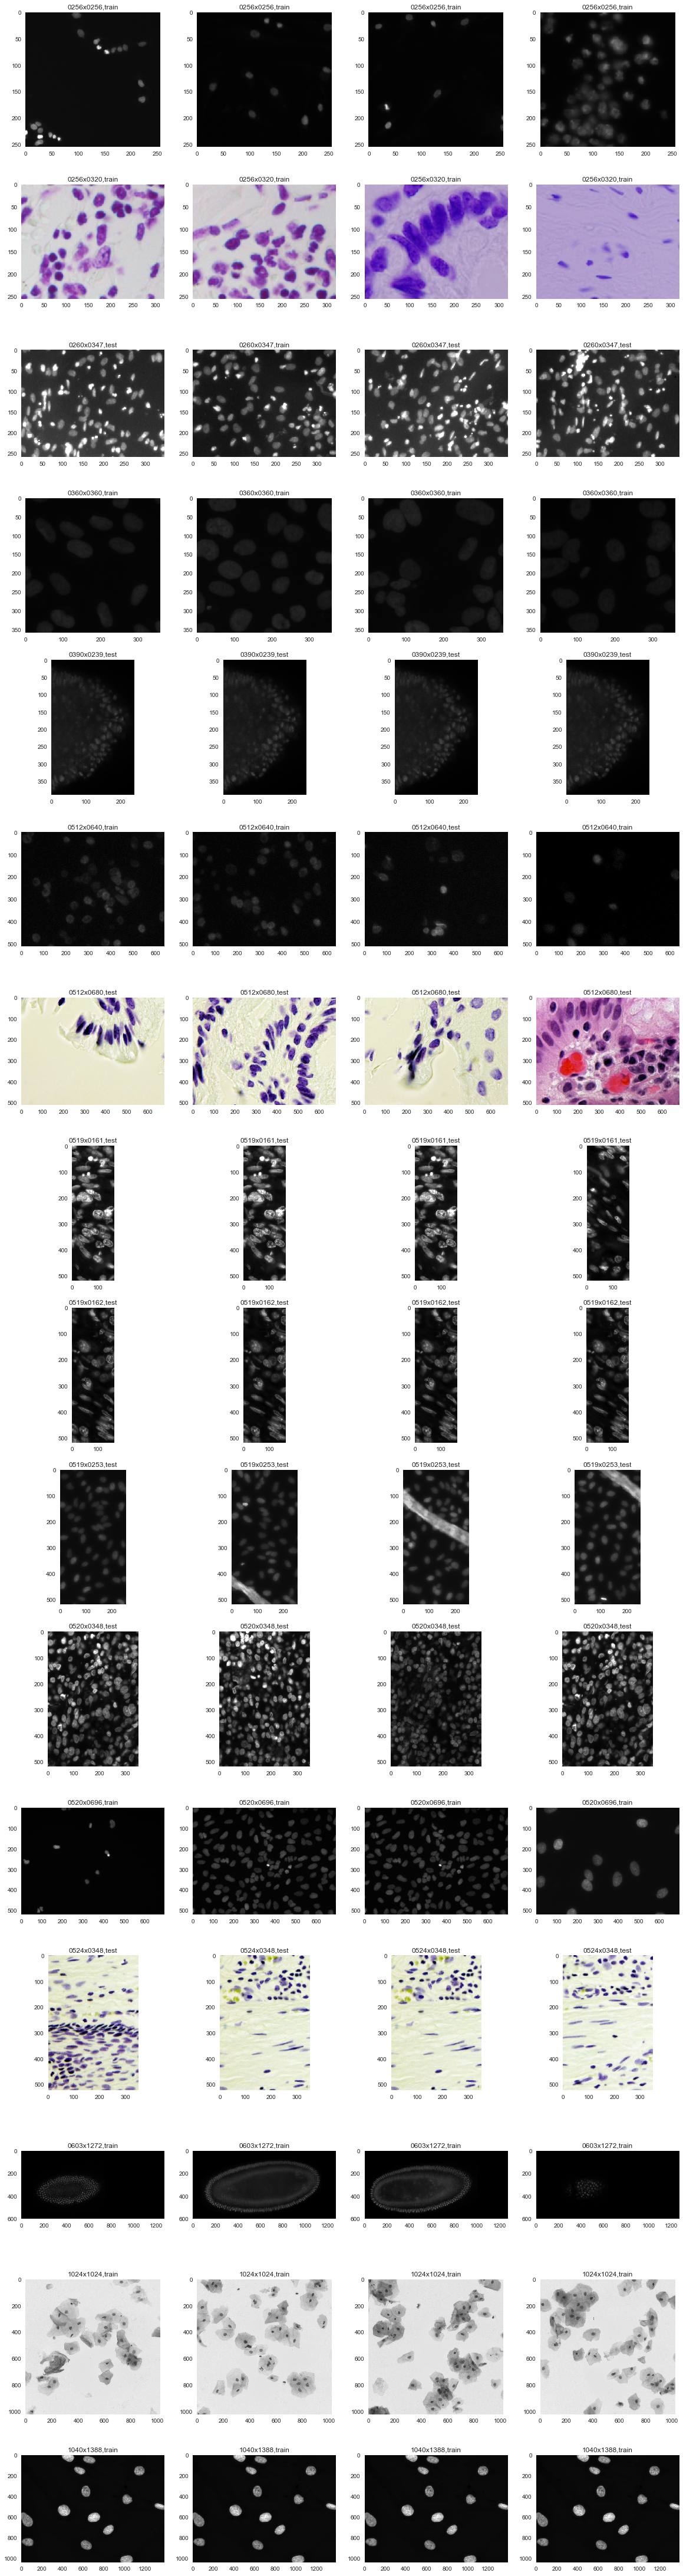

In [51]:
sample['label'] = sample[['shape','train_or_test']].apply(lambda x: '{},{}'.format(x[0],x[1]), axis=1)
show_row_col(sample,4,path_col='path',label_col='label',mode='file')